In [7]:
from pm4py.objects.log.importer.xes import importer as xes_import_factory
import pm4py

from pandas.api.types import is_numeric_dtype
import pingouin as pg

import pandas as pd
import numpy as np
import scipy

In [8]:
# ignore this part in true PowerBI executions
import os
import pandas as pd
from pm4py.objects.log.util import dataframe_utils

from pm4py.algo.discovery.dfg.adapters.pandas import df_statistics
from pm4py.statistics.attributes.pandas import get as attributes_get
from pm4py.statistics.start_activities.pandas import get as sa_get
from pm4py.statistics.end_activities.pandas import get as ea_get
from pm4py.visualization.dfg import visualizer


In [9]:
import tempfile

from pm4py.visualization.common import save
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import ipywidgets as widgets

In [10]:
def clean_df(df):

    explode_df = df.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1)
    
    explode_df['time:timestamp'] = explode_df[['intime', 'outtime']].values.tolist()
    explode_df['a'] = 'start'
    explode_df['b'] = 'complete'
    explode_df['lifecycle:transition'] = explode_df[['a', 'b']].values.tolist()
    explode_df = explode_df.explode(['time:timestamp', 'lifecycle:transition'])
    explode_df.drop(['intime', 'outtime', 'a', 'b'], axis=1 ,inplace=True)
    explode_df['concept:name'] = explode_df['department']
    explode_df['case:concept:name'] = explode_df['subject_id']
    return explode_df

In [11]:
csv_data = pd.read_csv('../Event Logs_2nd_Iteration/Heart_Failure_Log.csv')

csv_data = csv_data.drop(["Unnamed: 0.1", "Unnamed: 0"], axis=1)
csv_data = clean_df(csv_data)
csv_data

,subject_id,hadm_id,transfer_id,department,Glucose,Abnormal Glucose,Potassium,Abnormal Potassium,Sodium,Abnormal Sodium,...,o2sat,sbp,dbp,pain,acuity,chiefcomplaint,time:timestamp,lifecycle:transition,concept:name,case:concept:name
0,10559183,20008400.0,31433513,Emergency Department,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-03 13:32:00,start,Emergency Department,10559183
0,10559183,20008400.0,31433513,Emergency Department,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-03 16:00:00,complete,Emergency Department,10559183
1,10559183,20008400.0,36107959,Cardiac ICU,164.000000,1.0,4.316667,1.0,134.833333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-03 16:00:00,start,Cardiac ICU,10559183
1,10559183,20008400.0,36107959,Cardiac ICU,164.000000,1.0,4.316667,1.0,134.833333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-06 18:44:57,complete,Cardiac ICU,10559183
2,10559183,20008400.0,38390977,Post-ICU Cardiology,125.000000,1.0,4.300000,2.0,137.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2116-01-06 18:44:57,start,Post-ICU Cardiology,10559183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,11282384,29994261.0,30592303,Surgical ICU,138.833333,1.0,4.000000,2.0,142.333333,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-21 18:35:27,complete,Surgical ICU,11282384
4321,11282384,29994261.0,37585480,Post-ICU Medicine,114.333333,1.0,4.466667,2.0,142.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-21 18:35:27,start,Post-ICU Medicine,11282384
4321,11282384,29994261.0,37585480,Post-ICU Medicine,114.333333,1.0,4.466667,2.0,142.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-24 13:13:59,complete,Post-ICU Medicine,11282384
4322,11282384,29994261.0,39587256,Discharged,123.000000,1.0,4.300000,2.0,140.000000,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2124-09-24 13:13:59,start,Discharged,11282384


In [12]:
def prepare_dataframe_mean_per_activity_measurement(df):
    
    df_meaned = df.groupby(["case:concept:name", "concept:name"]).mean()
    df_aggregated = df_meaned.groupby(['concept:name']).agg(lambda x: x.dropna().tolist())
    df_melted = pd.melt(df_aggregated.reset_index(), id_vars='concept:name',
           value_vars=df_aggregated.columns
    )
    df_final = df_melted[df_melted['value'].map(lambda d: len(d)) > 0]
    return df_final.set_index(['concept:name', 'variable'])

In [13]:
def prepare_dataframe_mode_per_activity_measurement(df):
    
    df_meaned = df.groupby(["case:concept:name", "concept:name"])[list(df.select_dtypes(exclude=['datetimetz', "number","bool_", "datetime"]).columns)].agg(lambda x: scipy.stats.mode(x)[0])
    df_aggregated = df_meaned.groupby(['concept:name']).agg(lambda x: x.dropna().tolist())
    df_melted = pd.melt(df_aggregated.reset_index(), id_vars='concept:name',
           value_vars=df_aggregated.columns
    )
    df_final = df_melted[df_melted['value'].map(lambda d: len(d)) > 0]
    return df_final.set_index(['concept:name', 'variable'])

In [14]:
def join_prepared_dataframes(d1, d2):
    return d1.join(d2, on=['concept:name', 'variable'], lsuffix='_l', rsuffix='_r')

In [15]:
def do_mwu(row):
    mwu_results = pg.mwu(row["value_l"], row["value_r"])
    row['p-val'] = mwu_results['p-val'][0]
    row['RBC'] = mwu_results['RBC'][0]
    row['RBC_abs'] = abs(mwu_results['RBC'][0])
    row['CLES'] = mwu_results['CLES'][0]
    return row

In [105]:
def get_best_mwu_for_activity_filtered(df_mwu, activity, allowed_measurements='ALL'):
    df_mwu = df_mwu.reset_index()
    if allowed_measurements != "ALL":
        df_mwu = df_mwu[df_mwu['variable'].isin(allowed_measurements)]
    top_mwu = df_mwu.groupby("concept:name").head(1)
    res = top_mwu.reset_index().loc[top_mwu.reset_index()["concept:name"] == activity, "RBC_abs"]
    if len(res.values) > 0:
        return res.values[0]
    else:
        return 0

In [82]:
def do_chi_squared(row):
    
    left_df = pd.DataFrame(row["value_l"],columns =['values'])
    left_df['category'] = 'left'
    right_df = pd.DataFrame(row["value_r"],columns =['values'])
    right_df['category'] = 'right'
    df_concat = pd.concat([left_df, right_df])
    try:
        _, _, stats = pg.chi2_independence(df_concat, x='category', y='values')
        pearson_stats = stats[stats['test'] == 'pearson']
    except:
        pearson_stats = pd.Dataframe([100.0, 100.0, np.nan, np.nan, np.nan],columns=['pval', 'chi2', 'dof', 'power', 'cramer'])
    row['p-val'] = pearson_stats['pval'][0]
    row['RBC_abs'] = pearson_stats['chi2'][0]
    row['dof'] = pearson_stats['dof'][0]
    # pval und chi2 value for comparison
    row['power'] = pearson_stats['power'][0]
    row['cramer'] = pearson_stats['cramer'][0]
    return row

In [56]:
def build_dfg(base_dataset):
    dataset = dataframe_utils.convert_timestamp_columns_in_df(base_dataset)

    # this part is required because the dataframe provided by PowerBI has strings
    dataset["time:timestamp"] = pd.to_datetime(dataset["time:timestamp"])
    dataset = dataset.sort_values("time:timestamp")
    dfg = df_statistics.get_dfg_graph(dataset, measure="frequency")
    return dfg, dataset

In [95]:
def build_visualization(dfg, dataset, test_results, max_nodes, measurements):
    print(f"used measurements: {measurements}")
    activities_count = attributes_get.get_attribute_values(dataset, "concept:name")
    for activity in activities_count:
        activities_count[activity] = get_best_mwu_for_activity_filtered(test_results, activity, measurements)
    start_activities = sa_get.get_start_activities(dataset)
    end_activities = ea_get.get_end_activities(dataset)
    gviz = visualizer.apply(dfg, activities_count=activities_count, variant=visualizer.Variants.FREQUENCY,
                        parameters={"start_activities": start_activities, "end_activities": end_activities, "maxNoOfEdgesInDiagram": max_nodes})

    fig = plt.figure(figsize=(15,8))

    file_name = tempfile.NamedTemporaryFile(suffix='.png')
    file_name.close()

    save.save(gviz, file_name.name)

    img = mpimg.imread(file_name.name)
    plt.axis('off')
    plt.imshow(img)
    plt.show() 
    display(
test_results.reset_index()[test_results.reset_index()['variable'].isin(list(measurements))].groupby("concept:name").head(5)[['concept:name', 'variable', 'p-val']].set_index(['concept:name', 'variable']))

In [63]:
def prep_mwu(dataset1, dataset2):
    over_60_meaned = prepare_dataframe_mean_per_activity_measurement(dataset1)
    under_60_meaned = prepare_dataframe_mean_per_activity_measurement(dataset2)
    df_joined = join_prepared_dataframes(over_60_meaned, under_60_meaned)
    return df_joined

In [64]:
def run_mwu(df_joined):
    # run mann-whitney u test
    mwu_results = df_joined.apply(do_mwu, axis=1)
    mwu_results["count_l"] = mwu_results.apply(lambda x: len(x["value_l"]), axis=1)
    mwu_results["count_r"] = mwu_results.apply(lambda x: len(x["value_r"]), axis=1)
    # bonferroni correction
    mwu_results["p-val-threshold"] = mwu_results.apply(lambda x: 0.05 / min(len(x["value_l"]), len(x["value_r"])), axis=1)
    mwu_results = mwu_results[mwu_results["p-val"] < mwu_results["p-val-threshold"]]
    # sort values
    return mwu_results.sort_values(["concept:name", "RBC_abs"], ascending=False)


In [66]:
def prep_chi_squared(dataset1, dataset2):
    over_60_mode = prepare_dataframe_mode_per_activity_measurement(dataset1)
    #over_60_mode
    under_60_mode = prepare_dataframe_mode_per_activity_measurement(dataset2)
    #under_60_mode
    return join_prepared_dataframes(over_60_mode, under_60_mode)


In [99]:
def run_chi_squared(df_joined_mode):
    chi_results = df_joined_mode.apply(do_chi_squared, axis=1)
    # bonferroni correction
    chi_results["p-val-threshold"] = chi_results.apply(lambda x: 0.05 / min(len(x["value_l"]), len(x["value_r"])), axis=1)
    chi_results = chi_results[chi_results["p-val"] < chi_results["p-val-threshold"]]
    return chi_results.sort_values(["concept:name", "p-val"], ascending=True)

In [29]:
# ipywidget integration

max_nodes_widget = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1,
    description='Max Number of Nodes:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

measurements_widget  = widgets.SelectMultiple(
    options=mwu_results.reset_index()['variable'],
    value=['age'],
    #rows=10,
    description='Measurements',
    disabled=False
)



In [107]:
# dataset split
subject_over_60  = csv_data[csv_data['age']>60]['subject_id']
subject_under_60  = csv_data[csv_data['age']<=60]['subject_id']
over_60 = csv_data[csv_data['subject_id'].isin(subject_over_60)]
under_60 = csv_data[csv_data['subject_id'].isin(subject_under_60)]

In [19]:
# mann whitney u test
# bonferroni correction
# sort values

In [117]:
df_joined = prep_mwu(over_60, under_60)
mwu_results = run_mwu(df_joined)
# top measurements for activities
mwu_results.reset_index().groupby("concept:name").head(5)[['concept:name', 'variable', 'p-val']].set_index(['concept:name', 'variable'])

p-val
concept:name         variable                       
Surgical ICU         DBP                4.155474e-06
                     Temperature F      9.413181e-04
Pre-ICU Cardiology   Urea Nitrogen      1.526282e-03
                     Magnesium          2.381893e-03
Post-ICU Medicine    pH                 1.946342e-03
                     PT                 8.042031e-04
                     INR(PT)            7.906411e-04
                     Phosphate          1.073295e-04
                     Abnormal INR(PT)   4.362156e-04
Post-ICU Cardiology  MCV                6.793420e-05
                     Red Blood Cells    3.305883e-04
Medical ICU          DBP                1.700985e-06
                     Temperature F      3.854910e-06
                     Respiratory Rate   1.156665e-05
                     PT                 8.966515e-05
                     INR(PT)            3.283458e-04
Emergency Department age               7.088673e-101
                     dbp                3.094515e-04
Discharged           Phosphate          4.192497e-08
                     Sodium             1.893308e-06
                     MCV                5.032724e-05
                     Chloride           1.016561e-04
Cardiac ICU          DBP                6.724052e-15
                     Urea Nitrogen      3.045820e-06
                     MCV                4.864896e-06
                     Temperature F      3.861002e-05
                     MCH                3.686980e-04

In [75]:
# chi squared
# bonferroni correction
# sort values

In [100]:
df_mode_joined = prep_chi_squared(over_60, under_60)
chi_results = run_chi_squared(df_mode_joined)
chi_results

/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/scipy/stats/stats.py:6716: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
/opt/homebrew/Caskroom/miniforge/base/envs/dafdh/lib/python3.10/site-packages/scipy/stats/stats.py:6713: RuntimeWarning: divide by zero encountered in tru

value_l  \
concept:name         variable                                                                
Discharged           discharge_location  [DIED, HOME HEALTH CARE, HOME HEALTH CARE, SKI...   
Emergency Department marital_status      [WIDOWED, 0, MARRIED, WIDOWED, WIDOWED, MARRIE...   
                     insurance           [Medicare, Other, Medicare, Medicare, Medicare...   
                     ethnicity           [WHITE, UNKNOWN, WHITE, WHITE, WHITE, WHITE, W...   

                                                                                   value_r  \
concept:name         variable                                                                
Discharged           discharge_location  [HOME, DIED, HOME HEALTH CARE, HOME, REHAB, HO...   
Emergency Department marital_status      [SINGLE, WIDOWED, DIVORCED, MARRIED, SINGLE, D...   
                     insurance           [Other, Medicare, Medicare, Other, Other, Othe...   
                     ethnicity           [WHITE, WHITE, WHITE, WHITE, WHITE, WHITE, HIS...   

                                                p-val     RBC_abs   dof  \
concept:name         variable                                             
Discharged           discharge_location  4.877297e-24  140.441838  12.0   
Emergency Department marital_status      3.748947e-25  120.719818   4.0   
                     insurance           1.412985e-24  109.832675   2.0   
                     ethnicity           3.560489e-09   53.088778   7.0   

                                           power    cramer  p-val-threshold  
concept:name         variable                                                
Discharged           discharge_location  1.00000  0.387356         0.000263  
Emergency Department marital_status      1.00000  0.359130         0.000263  
                     insurance           1.00000  0.342553         0.000263  
                     ethnicity           0.99998  0.238157         0.000263

In [78]:
# mwu visualization

In [113]:
dfg, dataset = build_dfg(over_60)

/var/folders/2z/hk7x37vj029gb48kv3xv2_hh0000gn/T/ipykernel_58045/3195414031.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["time:timestamp"] = pd.to_datetime(dataset["time:timestamp"])


used measurements: ['DBP', 'Temperature F', 'Urea Nitrogen', 'Magnesium', 'pH', 'PT', 'INR(PT)', 'Phosphate', 'Abnormal INR(PT)', 'Abnormal PT', 'MCV', 'Red Blood Cells', 'DBP', 'Temperature F', 'Respiratory Rate', 'PT', 'INR(PT)', 'age', 'dbp', 'Phosphate', 'Sodium', 'MCV', 'Chloride', 'DBP', 'Urea Nitrogen', 'MCV', 'Temperature F', 'MCH']


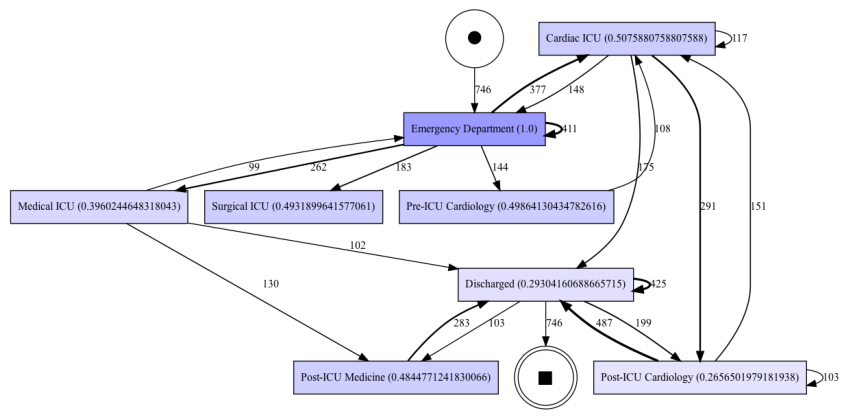

p-val
concept:name         variable                       
Surgical ICU         DBP                4.155474e-06
                     Temperature F      9.413181e-04
Pre-ICU Cardiology   Urea Nitrogen      1.526282e-03
                     Magnesium          2.381893e-03
Post-ICU Medicine    pH                 1.946342e-03
                     PT                 8.042031e-04
                     INR(PT)            7.906411e-04
                     Phosphate          1.073295e-04
                     Abnormal INR(PT)   4.362156e-04
Post-ICU Cardiology  MCV                6.793420e-05
                     Red Blood Cells    3.305883e-04
Medical ICU          DBP                1.700985e-06
                     Temperature F      3.854910e-06
                     Respiratory Rate   1.156665e-05
                     PT                 8.966515e-05
                     INR(PT)            3.283458e-04
Emergency Department age               7.088673e-101
                     dbp                3.094515e-04
Discharged           Phosphate          4.192497e-08
                     Sodium             1.893308e-06
                     MCV                5.032724e-05
                     Chloride           1.016561e-04
Cardiac ICU          DBP                6.724052e-15
                     Urea Nitrogen      3.045820e-06
                     MCV                4.864896e-06
                     Temperature F      3.861002e-05
                     MCH                3.686980e-04

In [114]:
build_visualization(dfg, dataset, mwu_results, 20, list(mwu_results.reset_index()['variable']))

In [110]:
display(max_nodes_widget)
display(measurements_widget)

IntSlider(value=7, continuous_update=False, description='Max Number of Nodes:')

SelectMultiple(description='Measurements', index=(0, 1, 2, 3, 4, 5, 6), options=('DBP', 'Temperature F', 'Urea…

used measurements: ('Temperature F', 'Magnesium', 'pH', 'PT')


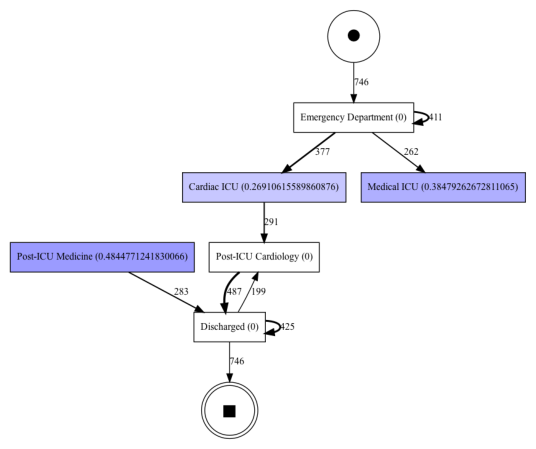

p-val
concept:name       variable               
Surgical ICU       Temperature F  0.000941
Pre-ICU Cardiology Magnesium      0.002382
Post-ICU Medicine  pH             0.001946
                   PT             0.000804
Medical ICU        Temperature F  0.000004
                   PT             0.000090
Cardiac ICU        Temperature F  0.000039

In [115]:
build_visualization(dfg, dataset, mwu_results, max_nodes_widget.value, measurements_widget.value)

used measurements: ['discharge_location', 'marital_status', 'insurance', 'ethnicity']


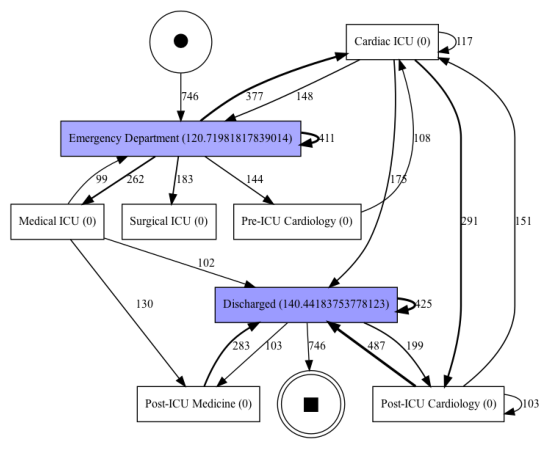

p-val
concept:name         variable                        
Discharged           discharge_location  4.877297e-24
Emergency Department marital_status      3.748947e-25
                     insurance           1.412985e-24
                     ethnicity           3.560489e-09

In [116]:
# chi squared visualization
build_visualization(dfg, dataset, chi_results, 20, list(chi_results.reset_index()['variable']))